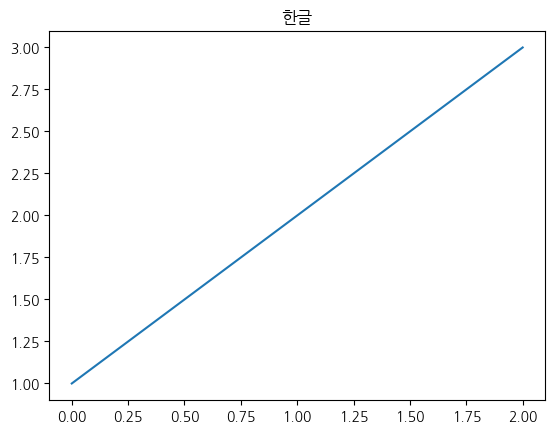

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

In [2]:
df = pd.read_csv('data/for_PCA_dong.csv')
df.head()
df.columns

Index(['자치구', '행정동', '행정동_코드', '월평균_총생활인구수', '연령대0_평균', '연령대10_평균', '연령대20_평균',
       '연령대30_평균', '연령대40_평균', '연령대50_평균', '연령대60_평균', '연령대70이상_평균', '1인가구',
       '2인가구', '3인가구', '4인가구', '5인가구', '6인가구', '7인 이상 가구', '연령대_100',
       '연령대_0_거주인구수', '연령대_10_거주인구수', '연령대_20_거주인구수', '연령대_30_거주인구수',
       '연령대_40_거주인구수', '연령대_50_거주인구수', '연령대_60_거주인구수', '연령대_70_거주인구수',
       '연령대_80_거주인구수', '연령대_90_거주인구수', '유흥주점영업', '단란주점', '제과점영업', '집단급식소',
       '일반음식점', '휴게음식점', '연령대_2030_거주인구수_합', '연령대_2030_거주인구수_평균',
       '연령대_20_거주인구수_비율', '연령대_30_거주인구수_비율', '연령대_2030_거주인구수_비율', '1인가구_비율',
       '식품접객업', '주점', '주요경제활동인구_거주인구수', '주요경제활동인구_생활인구수', 'PET예측량', '수거함_개수',
       '총_거주인구수', '수거함개수_당_거주인구'],
      dtype='object')

### 1. VIF로 다중공선성 체크
- 10이 넘는 변수 제거
- 초기 컬럼 선택 : '월평균_총생활인구수', '1인가구',
       '2인가구', '3인가구', '4인가구', '5인가구','유흥주점영업', '단란주점', '제과점영업', '집단급식소',
       '일반음식점', '휴게음식점', '연령대_2030_거주인구수_합', '연령대_2030_거주인구수_평균',
       '연령대_20_거주인구수_비율', '연령대_30_거주인구수_비율', '연령대_2030_거주인구수_비율', '1인가구_비율',
       '식품접객업', '주점', '주요경제활동인구_거주인구수', '주요경제활동인구_생활인구수', 'PET예측량', '수거함_개수',
       '총_거주인구수', '거주인구_당_수거함개수'

- 다중공선성으로 필터링 결과 : ['1인가구_비율','식품접객업', '주점', '주요경제활동인구_생활인구수', '수거함_개수','거주인구_당_수거함개수']
- 참고 : 상수항 (intercept)의 다중공선성이 높을 경우, 일반적으로 큰 문제가 되지는 않습니다. 

In [8]:
# x_features = ['1인가구_비율','식품접객업', '주점', '수거함개수_당_거주인구', '연령대_2030_거주인구수_합', '주요경제활동인구_생활인구수']
x_features = ['1인가구_비율','식품접객업', '연령대_2030_거주인구수_합', '주요경제활동인구_생활인구수']

# x_features에 대한 VIF 계산을 위해 상수(intercept) 열을 추가
x_features_with_const = sm.add_constant(df[x_features])

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = x_features_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(x_features_with_const.values, i) for i in range(x_features_with_const.shape[1])]
vif_data

,Variable,VIF
0,const,13.946742
1,1인가구_비율,1.149259
2,식품접객업,2.112633
3,연령대_2030_거주인구수_합,1.072062
4,주요경제활동인구_생활인구수,2.200066


### 2. Best Subset Selection
- 모든 가능한 독립 변수의 조합을 고려하여 최적의 모델을 선택하는 방법 
- 우리는 AIC 를 기반으로 
- AIC (Akaike Information Criterion):
AIC는 모델의 적합도와 모델의 복잡성을 고려하여 모델 선택을 합니다. <br>
AIC가 낮을수록 모델의 예측 성능이 좋으며, 데이터에 더 잘 적합됩니다.<br>
데이터에 대한 적합성을 높이는 데 초점을 맞추고, 모델의 복잡성을 상대적으로 덜 고려할 때 사용됩니다.<br>
**작은 크기의 데이터셋 또는 더 유연한 모델 선택**을 할 때 유용합니다.


- BIC (Bayesian Information Criterion):
BIC는 AIC와 마찬가지로 적합도와 복잡성을 고려하지만, 모델의 크기에 민감하게 반응합니다.<br>
BIC가 낮을수록 모델의 예측 성능이 좋으며, 데이터에 더 잘 적합됩니다. 그러나 BIC는 모델의 크기를 더 강력하게 제한합니다.<br>
데이터에 대한 적합성을 고려하면서, 불필요한 변수를 제한하고 모델의 단순성을 강조할 때 사용됩니다.<br>
**큰 크기의 데이터셋 또는 변수 선택에 제한**을 두고 싶을 때 유용합니다.

In [9]:
import itertools
import statsmodels.api as sm

# 종속 변수 설정
y = df['PET예측량']

# 독립 변수 리스트 (const 를 제외한 변수들)
independent_variables = vif_data.iloc[1:, 0].tolist()

# 최적 모델 초기화
best_model = None
best_model_summary = None
best_aic = float('inf')

best_bic_model = None
best_bic_model_summary = None
best_bic = float('inf')

# Best Subset Selection
for k in range(1, len(independent_variables) + 1):
    for subset in itertools.combinations(independent_variables, k):
        X_subset = df[list(subset)]
        X_subset = sm.add_constant(X_subset)
        model = sm.OLS(y, X_subset).fit()
        
        aic = model.aic
        bic = model.bic
        
        if aic < best_aic:
            best_aic = aic
            best_aic_model = model
            best_aic_model_summary = model.summary()
        
        if bic < best_bic:
            best_bic = bic
            best_bic_model = model
            best_bic_model_summary = model.summary()

print("### Best Subset Selection 결과 (AIC):")
print(best_aic_model_summary)

print('\n\n')

print("### Best Subset Selection 결과 (BIC):")
print(best_bic_model_summary)

### Best Subset Selection 결과 (AIC):
                            OLS Regression Results                            
Dep. Variable:                 PET예측량   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     487.4
Date:                Wed, 25 Oct 2023   Prob (F-statistic):           1.65e-70
Time:                        11:18:45   Log-Likelihood:                -474.35
No. Observations:                 134   AIC:                             956.7
Df Residuals:                     130   BIC:                             968.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
cons

### 최종변수 + 추가변수 후 PCA